# DR7.1 GMMs

The goal of this notebook is to generate Gaussian mixture models (GMMs) from DR7 photometry and morphologies of ELG, LRG, and BGS targets.

John Moustakas  
Siena College  
2018 September

In [1]:
import os
import warnings
import numpy as np
from pkg_resources import resource_filename

In [2]:
import fitsio
from astropy.table import Table, Column
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [3]:
from desiutil.sklearn import GaussianMixtureModel
from desitarget.targetmask import desi_mask

In [4]:
import matplotlib.pyplot as plt
import corner as cn

In [5]:
import seaborn as sns
rc = {'font.family': 'serif'}#, 'text.usetex': True}

In [6]:
%matplotlib inline

#### Simulation variables

In [7]:
dr = 'dr7.1'
seed = 999
rand = np.random.RandomState(seed)
overwrite = False

### Read the reference target catalog.

In [8]:
def read_targets(dr='dr7.1', nsample=2000000):
    if dr == 'dr7.1':
        ver = '0.23.0'
    targetsfile = os.path.join(os.getenv('DESI_ROOT'), 'target', 'catalogs', '{}'.format(dr), 
                          ver, 'targets-{}-{}.fits'.format(dr, ver))

    info = fitsio.FITS(targetsfile)
    nrows = info[1].get_nrows()
    these = rand.choice(nrows, size=nsample, replace=False)
    targets = Table(fitsio.read(targetsfile, rows=these))
    print('Read {} / {} objects from {}'.format(nsample, nrows, targetsfile))
    
    return targets

In [9]:
%time targets = read_targets(dr=dr)

Read 2000000 / 72660205 objects from /global/project/projectdirs/desi/target/catalogs/dr7.1/0.23.0/targets-dr7.1-0.23.0.fits
CPU times: user 9.11 s, sys: 6.17 s, total: 15.3 s
Wall time: 16.6 s


### Some basic QA.

In [10]:
def qa_bic(ncomp, bic, title='Object', png=None):
    ncompbest = ncomp[np.argmin(bic)]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic / 100, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion / 100')
    ax.set_title('{}: NGauss = {:d}'.format(title, ncompbest))
    if png:
        plt.savefig(png)

In [11]:
def qa_corner(Xdata, Xsample, labels, target='ELG', morph='DEV'):
    fig = cn.corner(Xdata, labels=labels, label_kwargs={'fontsize': 14}, 
                    show_titles=True, title_kwargs={'fontsize': 12},
                    color='k', quiet=True, hist2d_kwargs={'quiet': True},)
    fig.suptitle('{}/{}s Training Sample={} (grayscale), GMM Samples={} (green points)'.format(
        target, morph.strip(), Xdata.shape[0], Xsample.shape[0]))
    
    nobj, ndim = Xdata.shape
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.scatter(Xsample[:, xi], Xsample[:, yi], marker='s', 
                       color='g', s=5, alpha=0.5)
    if ndim > 3:
        fig.subplots_adjust(top=0.88)

### Wrapper functions for the Gaussian mixture modeling.

In [12]:
def get_data(target='ELG', morph='EXP ', Nmax=None):
    """Build the data matrix."""
    from desitarget.targetmask import desi_mask, mws_mask, bgs_mask
    
    if 'BGS' in target:
        indx_targ = (targets['DESI_TARGET'] & desi_mask.BGS_ANY) != 0
    else:
        indx_targ = (targets['DESI_TARGET'] & desi_mask.mask(target.strip())) != 0
    
    with np.errstate(all='ignore'):
        # Soft cuts on grz S/N and shape measurements.
        indx_flux = ( (targets['TYPE'] == morph) * 
                      (targets['BRIGHTSTARINBLOB'] == False) * # note!
                      (targets['FLUX_G'] * np.sqrt(targets['FLUX_IVAR_G']) > 1) * 
                      (targets['FLUX_R'] * np.sqrt(targets['FLUX_IVAR_R']) > 1) * 
                      (targets['FLUX_Z'] * np.sqrt(targets['FLUX_IVAR_Z']) > 1) )
    
        indx_rex = ( (targets['SHAPEEXP_R'] * np.sqrt(targets['SHAPEEXP_R_IVAR'])) > 1 )
        indx_exp = ( ( (targets['SHAPEEXP_R'] * np.sqrt(targets['SHAPEEXP_R_IVAR'])) > 1 ) *
                     ( (targets['SHAPEEXP_E1'] * np.sqrt(targets['SHAPEEXP_E1_IVAR'])) > 1 ) *
                     ( (targets['SHAPEEXP_E2'] * np.sqrt(targets['SHAPEEXP_E2_IVAR'])) > 1 ) )
        indx_dev = ( ( (targets['SHAPEDEV_R'] * np.sqrt(targets['SHAPEDEV_R_IVAR'])) > 1 ) *
                     ( (targets['SHAPEDEV_E1'] * np.sqrt(targets['SHAPEDEV_E1_IVAR'])) > 1 ) *
                     ( (targets['SHAPEDEV_E2'] * np.sqrt(targets['SHAPEDEV_E2_IVAR'])) > 1 ) )

        if morph.strip() == 'PSF':
            indx = indx_targ * indx_flux
        elif morph.strip() == 'REX':
            indx = indx_targ * indx_flux * indx_rex
        elif morph.strip() == 'EXP':
            indx = indx_targ * indx_flux * indx_exp
        elif morph.strip() == 'DEV':
            indx = indx_targ * indx_flux * indx_dev
        elif morph.strip() == 'COMP':
            indx = (indx_targ * indx_flux * indx_exp * indx_dev * 
                    ( (targets['FRACDEV'] * np.sqrt(targets['FRACDEV_IVAR'])) > 2 ) )
            
        nobj = np.count_nonzero(indx)
        #print('Selected {} {}s with morph={}'.format(nobj, target, morph))
        if nobj == 0:
            return np.array([]), [], []
    
        if morph.strip() == 'REX':
            rex_reff = np.log10(targets['SHAPEEXP_R'][indx])
            rex_reff_snr = np.log10(targets['SHAPEEXP_R'][indx] * np.sqrt(targets['SHAPEEXP_R_IVAR'][indx]))
            
        if morph.strip() == 'EXP' or morph.strip() == 'COMP':
            exp_reff = np.log10(targets['SHAPEEXP_R'][indx])
            exp_e1 = targets['SHAPEEXP_E1'][indx]
            exp_e2 = targets['SHAPEEXP_E2'][indx]
            exp_reff_snr = np.log10(targets['SHAPEEXP_R'][indx] * np.sqrt(targets['SHAPEEXP_R_IVAR'][indx]))
            exp_e1_snr = np.log10(targets['SHAPEEXP_E1_IVAR'][indx] * np.sqrt(targets['SHAPEEXP_E1_IVAR'][indx]))
            exp_e2_snr = np.log10(targets['SHAPEEXP_E2'][indx] * np.sqrt(targets['SHAPEEXP_E2_IVAR'][indx]))
        
        if morph.strip() == 'DEV' or morph.strip() == 'COMP':
            dev_reff = np.log10(targets['SHAPEDEV_R'][indx])
            dev_e1 = targets['SHAPEDEV_E1'][indx]
            dev_e2 = targets['SHAPEDEV_E2'][indx]
            dev_reff_snr = np.log10(targets['SHAPEDEV_R'][indx] * np.sqrt(targets['SHAPEDEV_R_IVAR'][indx]))
            dev_e1_snr = np.log10(targets['SHAPEDEV_E1_IVAR'][indx] * np.sqrt(targets['SHAPEDEV_E1_IVAR'][indx]))
            dev_e2_snr = np.log10(targets['SHAPEDEV_E2'][indx] * np.sqrt(targets['SHAPEDEV_E2_IVAR'][indx]))
        
        if morph.strip() == 'COMP':
            fracdev = targets['FRACDEV'][indx]
            fracdev_snr = np.log10(targets['FRACDEV'][indx] * np.sqrt(targets['FRACDEV_IVAR'][indx]))
                
        gmag = 22.5 - 2.5 * np.log10(targets['FLUX_G'][indx])
        rmag = 22.5 - 2.5 * np.log10(targets['FLUX_R'][indx])
        zmag = 22.5 - 2.5 * np.log10(targets['FLUX_Z'][indx])
        gr = gmag - rmag
        rz = rmag - zmag

    if target == 'LRG':
        X = np.vstack( (zmag, gr, rz) )
        maglabel = 'z'
    else:
        X = np.vstack( (rmag, gr, rz) )
        maglabel = 'r'
    
    if morph.strip() == 'PSF':
        labels = (maglabel, 'g - r', 'r - z')
        columns = (maglabel, 'gr', 'rz')
        
    if morph.strip() == 'REX':
        X = np.vstack( (X, rex_reff, rex_reff_snr) )
        labels = (maglabel, 'g - r', 'r - z', 
                  r'$\log_{10}(r_{eff,rex}$ (arcsec)', r'$\log_{10}(S/N\ r_{eff,rex})$')
        columns = (maglabel, 'gr', 'rz', 'reff_rex', 'snr_reff_rex')
        
    if morph.strip() == 'EXP':
        X = np.vstack( (X, exp_reff, exp_e1, exp_e2, exp_reff_snr, exp_e1_snr, exp_e2_snr) )
        labels = (maglabel, 'g - r', 'r - z', 
                  r'$\log_{10}(r_{eff,exp}$ (arcsec)', r'$e_{1,exp}$', r'$e_{2,exp}$', 
                  r'$\log_{10}(S/N\ r_{eff,exp})$', r'$\log_{10}(S/N\ e_{1,exp})$', r'$\log_{10}(S/N\ e_{2,exp})$')
        columns = (maglabel, 'gr', 'rz', 
                   'reff_exp', 'e1_exp', 'e2_exp', 
                   'snr_reff_exp', 'snr_e1_exp', 'snr_e2_exp')

    if morph.strip() == 'DEV':
        X = np.vstack( (X, dev_reff, dev_e1, dev_e2, dev_reff_snr, dev_e1_snr, dev_e2_snr) )
        labels = (maglabel, 'g - r', 'r - z', 
                  r'$\log_{10}(r_{eff,dev}$ (arcsec)', r'$e_{1,dev}$', r'$e_{2,dev}$', 
                  r'$\log_{10}(S/N\ r_{eff,dev})$', r'$\log_{10}(S/N\ e_{1,dev})$', r'$\log_{10}(S/N\ e_{2,dev})$')
        columns = (maglabel, 'gr', 'rz', 
                   'reff_dev', 'e1_dev', 'e2_dev', 
                   'snr_reff_dev', 'snr_e1_dev', 'snr_e2_dev')

    if morph.strip() == 'COMP':
        X = np.vstack( (X, 
                        exp_reff, exp_e1, exp_e2, dev_reff, dev_e1, dev_e2, fracdev,
                        exp_reff_snr, exp_e1_snr, exp_e2_snr, dev_reff_snr, dev_e1_snr, dev_e2_snr, fracdev_snr
                       ) )
        labels = (maglabel, 'g - r', 'r - z', 
                  r'$\log_{10}(r_{eff,exp}$ (arcsec)', r'$e_{1,exp}$', r'$e_{2,exp}$', 
                  r'$\log_{10}(r_{eff,dev}$ (arcsec)', r'$e_{1,dev}$', r'$e_{2,dev}$', r'$Fracdev$',
                  r'$\log_{10}(S/N\ r_{eff,exp})$', r'$\log_{10}(S/N\ e_{1,exp})$', r'$\log_{10}(S/N\ e_{2,exp})$',
                  r'$\log_{10}(S/N\ r_{eff,dev})$', r'$\log_{10}(S/N\ e_{1,dev})$', r'$\log_{10}(S/N\ e_{2,dev})$',
                  r'$\log_{10}(S/N\ Fracdev)$')
        columns = (maglabel, 'gr', 'rz', 
                   'reff_exp', 'e1_exp', 'e2_exp', 
                   'reff_dev', 'e1_dev', 'e2_dev', 'fracdev',
                   'snr_reff_exp', 'snr_e1_exp', 'snr_e2_exp',
                   'snr_reff_dev', 'snr_e1_dev', 'snr_e2_dev', 'snr_fracdev')

    #import pdb ; pdb.set_trace()
        
    if Nmax is not None and Nmax <= nobj:
        these = rand.choice(nobj, size=Nmax, replace=False)
        X = X[:, these]
            
    return X.T, labels, columns

In [13]:
def get_mog_bic(X, ncomp, rand=None):
    """Compute the MoG and BIC for a range of Gaussian components."""
    mog = [GMM(n_components=nc, random_state=rand).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    return mog, np.array(bic)

In [14]:
def build_gmm(X, ncompmin=1, ncompmax=5, target='', morph='',
              columns=None, rand=None, png=None, overwrite=False):
    """Find the optimal GMM."""
    from astropy.io import fits

    if rand is None:
        rand = np.random.RandomState()
    ncomp = np.arange(ncompmin, ncompmax+1)

    gmmfile = resource_filename( 'desitarget', 'mock/data/{}/gmm_{}_{}.fits'.format(
        dr, target.lower(), morph.strip().lower()) )
    os.makedirs(os.path.dirname(gmmfile), exist_ok=True)
    
    if ~os.path.isfile(gmmfile) or overwrite:
        #print('Generating a GMM for {}/{} with N={}-{} components from {} objects.'.format(
        #    target, morph.strip(), ncompmin, ncompmax, X.shape[0]))
        allmog, bic = get_mog_bic(X, ncomp, rand=rand)
        qa_bic(ncomp, bic, png=png, title='{}/{}s (N={})'.format(
            target, morph.strip(), X.shape[0]))
    
        print('Writing {}'.format(gmmfile))
        mog = allmog[np.argmin(bic)] # minimize the BIC
        GaussianMixtureModel.save(mog, gmmfile)
            
        # Update the FITS header with the column names.
        if columns is not None: 
            with fits.open(gmmfile, 'update') as ff:
                ff[0].header['NCOL'] = len(columns)
                for ii, col in enumerate(columns):
                    ff[0].header['COL{:02d}'.format(ii)] = col
    
    # (Re)read the model to get a few more convenience methods.
    #print('Reading {}'.format(gmmfile))
    mog = GaussianMixtureModel.load(gmmfile)

    return mog

### Get the fraction of morphological type for each target type as a function of magnitude.

In [15]:
def maghist_bins(deltam=0.5, minmag=19, maxmag=24, target='ELG', binedges=False):
    """Magnitude bins."""
    if target.strip() == 'LRG':
        minmag, maxmag = 18.0, 21.0
    elif target.strip() == 'BGS':
        minmag, maxmag = 14.0, 20.0
    else:
        minmag, maxmag = 19.0, 24.0
        
    if binedges:
        bins = np.arange(minmag, maxmag, deltam) # bin left edges
    else:
        bins = np.arange(minmag, maxmag, deltam) + deltam / 2 # bin centers
        
    return bins

In [16]:
def maghist_type(data, target='ELG'):
    """Fraction of a given morphological types as a function of magnitude."""
    bins = maghist_bins(target=target, binedges=True)
    hist, _ = np.histogram( data, bins=len(bins), range=(bins.min(), bins.max()) )
    return hist

In [17]:
def qa_maghist(data, target='ELG'):
    """Simple QA plot."""
    fig, ax = plt.subplots(figsize=(8, 6))
    magbins = data['MAG']
    ls = iter(['-', '--', '-.', ':', '-'])
    marker = iter(['s', 'o', '^', 'D', 'p'])
    
    for morph in ('PSF', 'REX', 'EXP', 'DEV', 'COMP'):
        if morph in data.colnames:
            good = data[morph] > 0
            ax.plot(magbins[good], data[morph][good], '{}{}'.format(next(ls), next(marker)),
                    label=morph, lw=2, markersize=10)#, ls=next(ls)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Morphological Type Fraction')

    if target == 'LRG':
        ax.set_xlabel('$z$ (AB mag)')
    else:
        ax.set_xlabel('$r$ (AB mag)')
    ax.text(0.1, 0.95, target, ha='left', va='top', 
            transform=ax.transAxes, fontsize=18)
    ax.legend(loc='upper right')

In [18]:
def maghist_normalize(maghist, target='ELG'):
    """Normalize the type fractions and write out."""
    morph = [mm.strip() for mm in maghist.keys()]
    typefrac = [maghist[mm] for mm in maghist.keys()]

    frac = np.vstack(typefrac).astype('f4')
    tot = np.sum(frac, axis=0)
    normfrac = np.zeros_like(frac)
    notzero = np.where( tot > 0 )[0]
    for ii in range(frac.shape[0]):
        normfrac[ii, notzero] = frac[ii, notzero] / tot[notzero]
    
    out = Table()
    #out.add_column(Column(name='MORPH', data=morph))
    out.add_column(Column(name='MAG', data=maghist_bins(target=target), dtype='f4'))
    for ii, mm in enumerate(morph):
        out.add_column(Column(name=mm, data=normfrac[ii, :], dtype='f4'))
                         
    return out

In [19]:
def get_maghist(target, Nmax=50000, overwrite=False):
    """Get the magnitude histogram of each morphological type."""
    maghist = dict()
    for morph in ('PSF ', 'REX ', 'EXP ', 'DEV ', 'COMP'):
        X, labels, _ = get_data(target=target, morph=morph, Nmax=Nmax)
        if X.shape[0] == 0:
            continue
        maghist[morph.strip()] = maghist_type(X[:, 0], target=target)

    out = maghist_normalize(maghist, target=target)

    # Write out
    fracfile = resource_filename( 'desitarget', 'mock/data/{}/fractype_{}.fits'.format(
        dr, target.lower()))
    os.makedirs(os.path.dirname(fracfile), exist_ok=True)
    if ~os.path.isfile(fracfile) or overwrite:
        print('Writing {}'.format(fracfile))
        out.write(fracfile, overwrite=True)

    qa_maghist(out, target=target)
        
    return out

In [20]:
sns.set(style='ticks', font_scale=1.5, palette='Set2', rc=rc)

Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/fractype_bgs.fits
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/fractype_elg.fits
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/fractype_lrg.fits


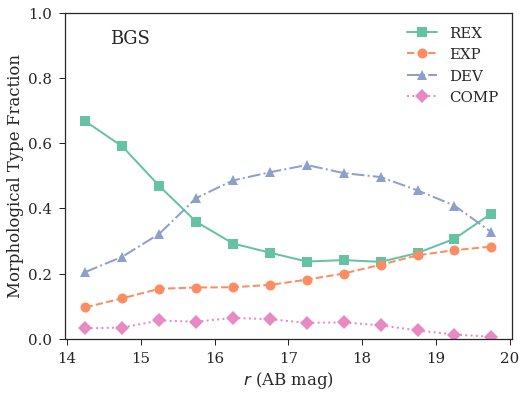

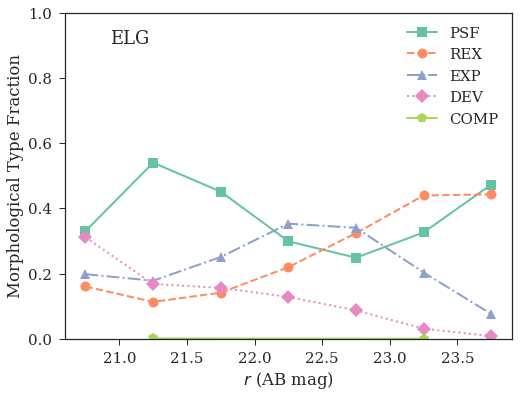

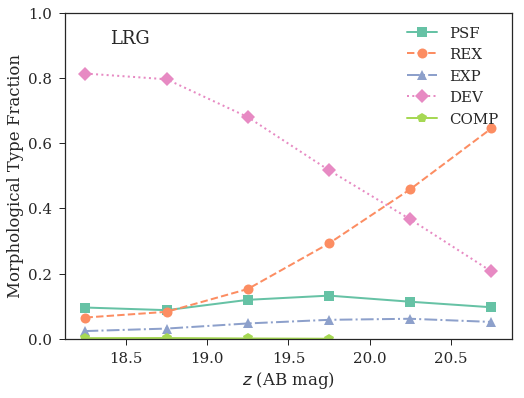

In [21]:
for target in ('BGS', 'ELG', 'LRG'):
    out = get_maghist(target, overwrite=overwrite)

### Now train and validate the GMMs for each combination of target and morphological type.

In [22]:
def train_and_validate(target, morph=None, Nmax=50000, Nsample=500, ncompmin=1, 
                       ncompmax=20, train_size=0.8, overwrite=False):
    
    test_size = 1-train_size
    if morph is None:
        morph = ('PSF ', 'REX ', 'EXP ', 'DEV ', 'COMP')
    
    for mm in np.atleast_1d(morph):
        X, labels, columns = get_data(target=target, morph=mm, Nmax=Nmax) # Nmax=20000)
        
        if X.shape[0] > 3*ncompmax:
            print('Training:testing {}:{} {}/{}s with {}-{} Gaussian components.'.format(
                np.round(X.shape[0]*train_size).astype('int'), np.round(X.shape[0]*test_size).astype('int'),
                target, mm.strip(), ncompmin, ncompmax))
        else:
            if X.shape[0] == 0:
                print('No  {}/{}s selected.'.format(target, mm))
            else:
                print('Only {} {}/{}s selected.'.format(X.shape[0], target, mm))
            continue

        Xtrain, Xvalidate = train_test_split(X, train_size=train_size, 
                                             test_size=1-train_size,
                                             random_state=rand)
    
        mog = build_gmm(Xtrain, ncompmin=ncompmin, ncompmax=ncompmax, 
                        overwrite=overwrite, target=target, 
                        morph=mm, rand=rand, columns=columns, 
                        png=None)
    
        Xsample = mog.sample(Nsample, random_state=rand)
        qa_corner(Xvalidate, Xsample, labels, target=target, morph=mm)
        
        print()

In [23]:
sns.reset_orig()
ncompmax = 20

### LRG

Training:testing 2915:729 LRG/PSFs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_lrg_psf.fits



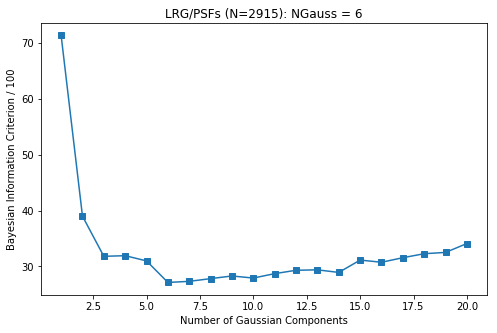

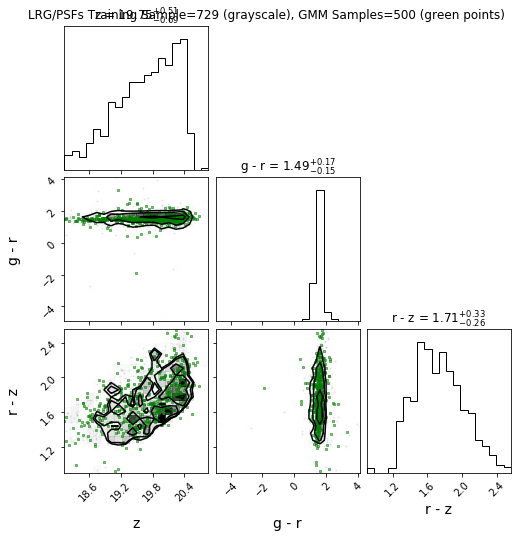

In [24]:
train_and_validate('LRG', morph='PSF ', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

Training:testing 2915:729 LRG/PSFs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_lrg_psf.fits

Training:testing 10931:2733 LRG/REXs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_lrg_rex.fits

Training:testing 1385:346 LRG/EXPs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_lrg_exp.fits

Training:testing 11254:2814 LRG/DEVs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_lrg_dev.fits

Only 13 LRG/COMPs selected.
CPU times: user 59.8 s, sys: 297 ms, total: 1min
Wall time: 1min


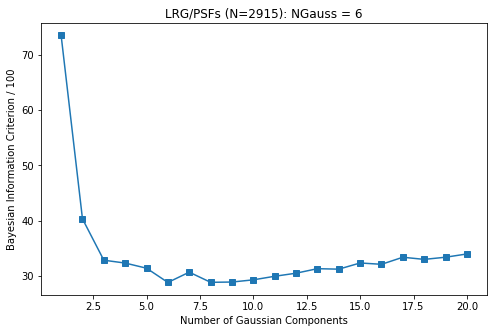

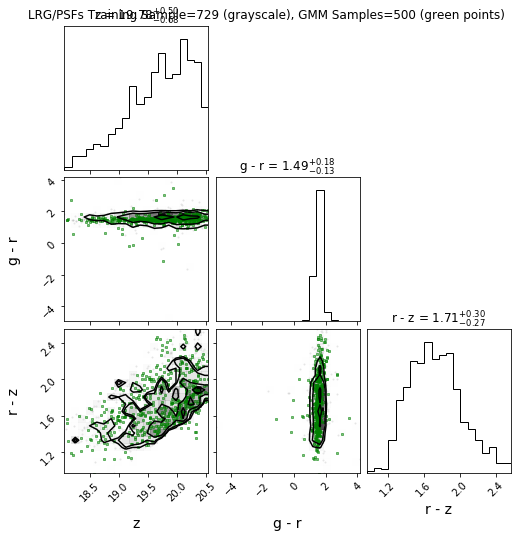

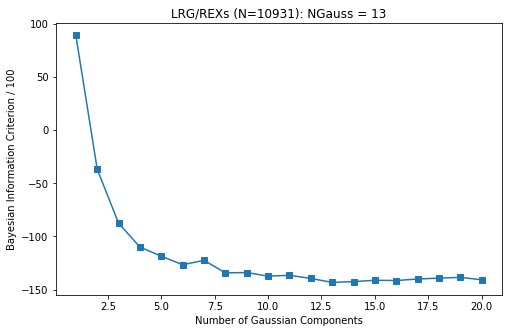

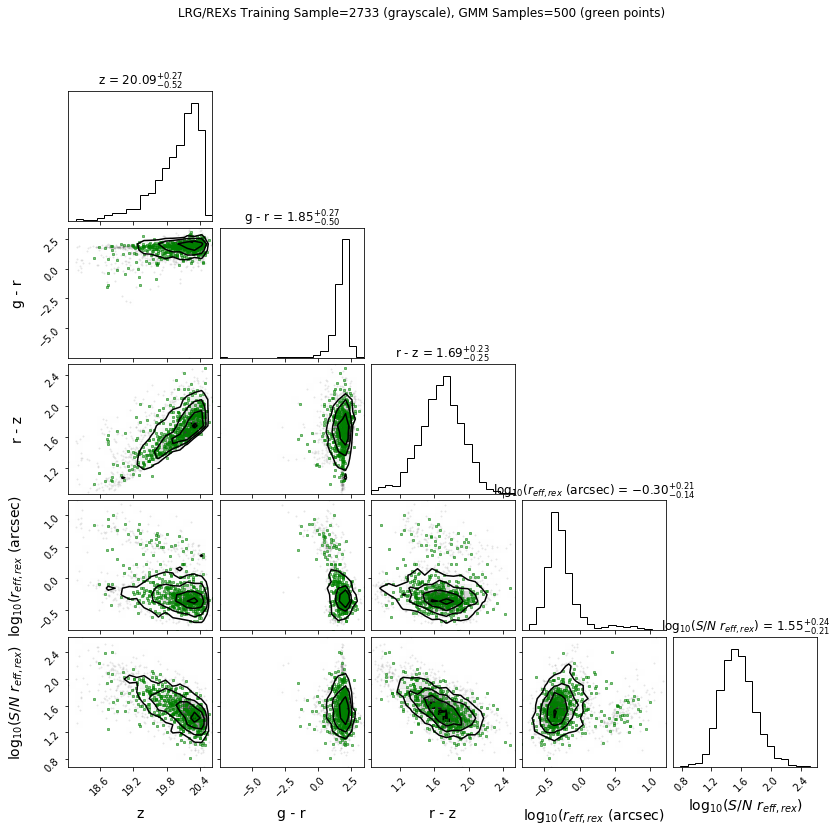

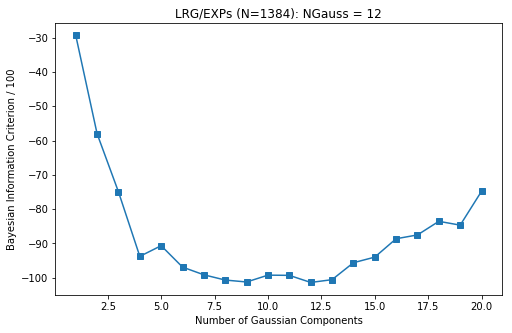

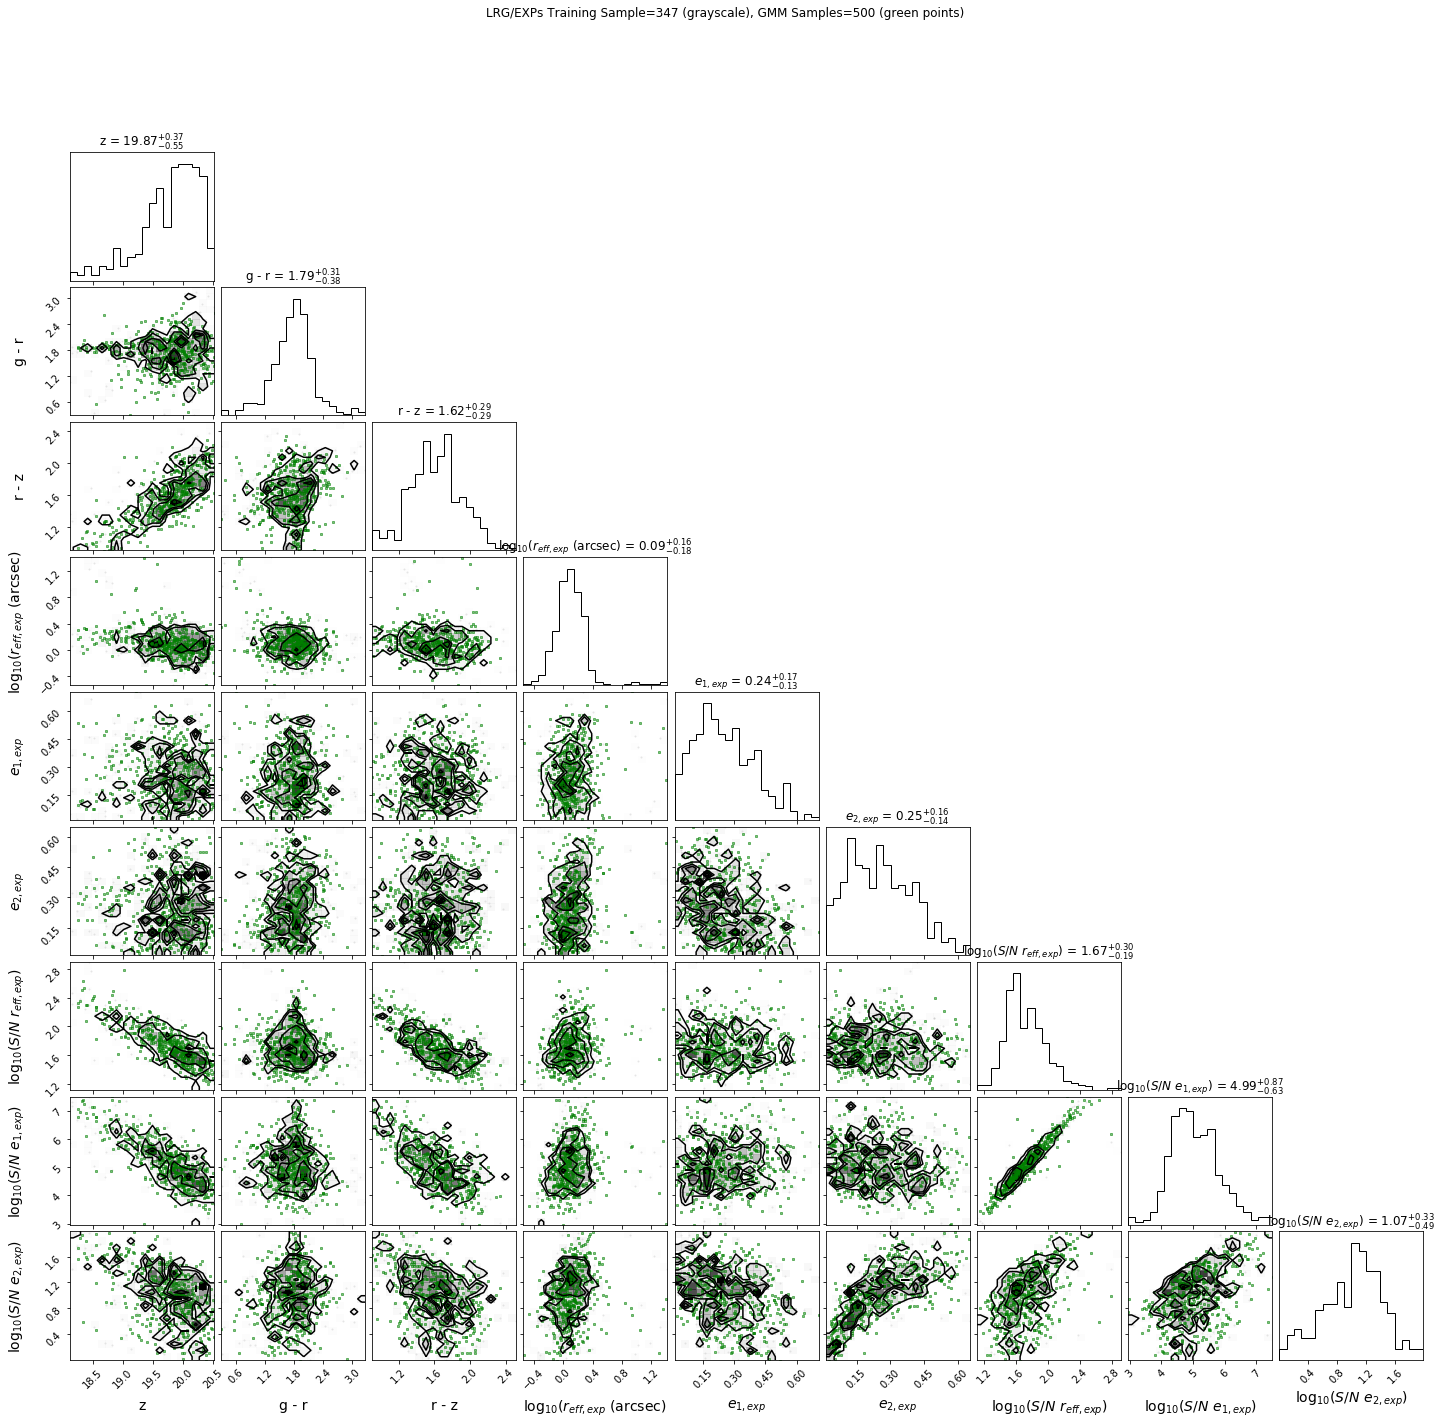

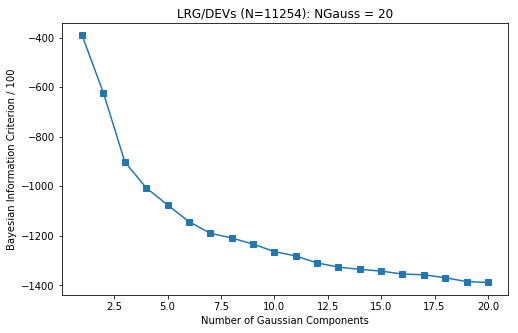

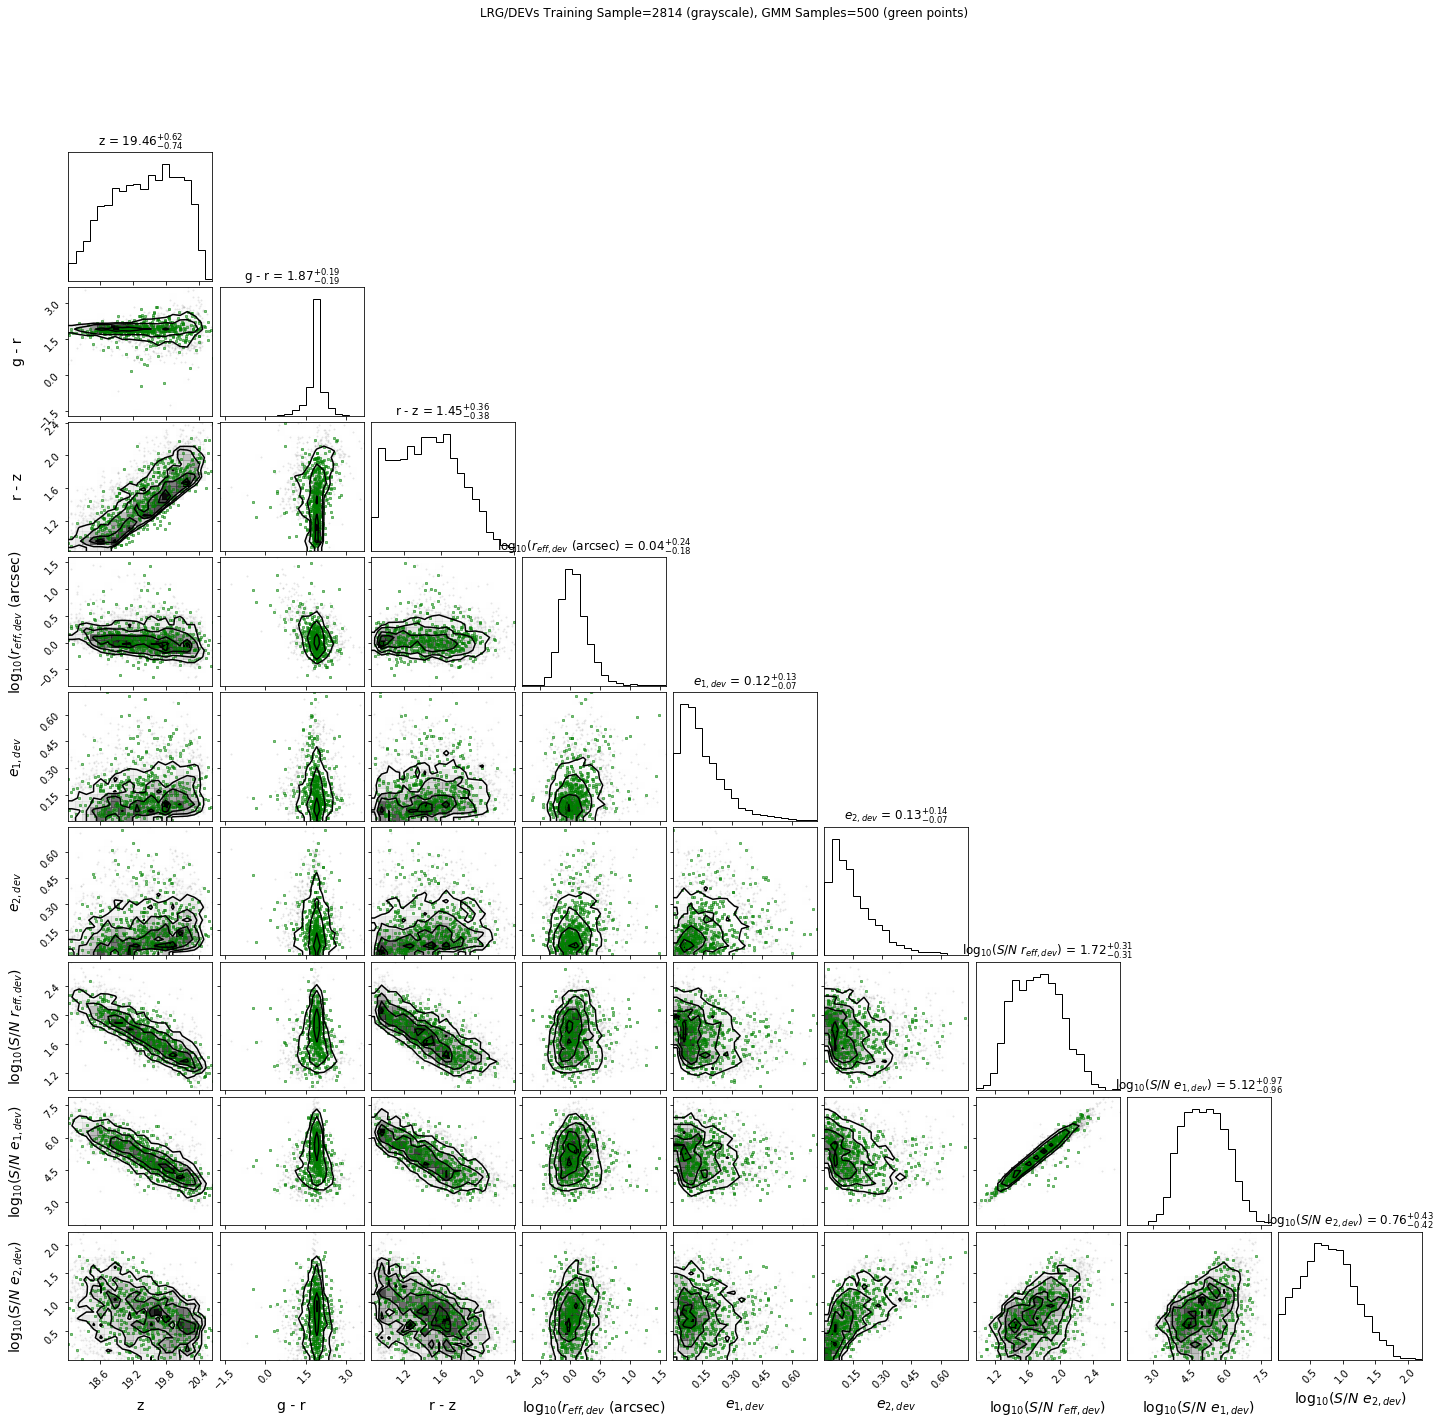

In [25]:
%time train_and_validate('LRG', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

### ELG

Training:testing 92888:23222 ELG/PSFs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_elg_psf.fits

Training:testing 435729:108932 ELG/REXs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_elg_rex.fits

Training:testing 15497:3874 ELG/EXPs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_elg_exp.fits

Training:testing 3361:840 ELG/DEVs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_elg_dev.fits

Only 2 ELG/COMPs selected.
CPU times: user 13min 37s, sys: 1min 55s, total: 15min 32s
Wall time: 17min 7s


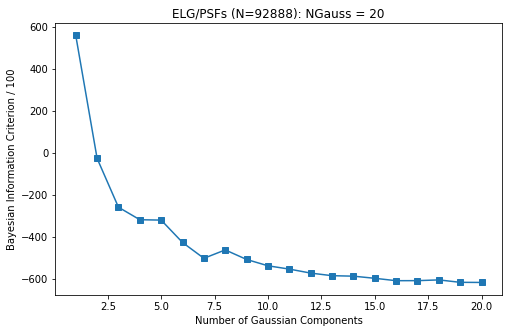

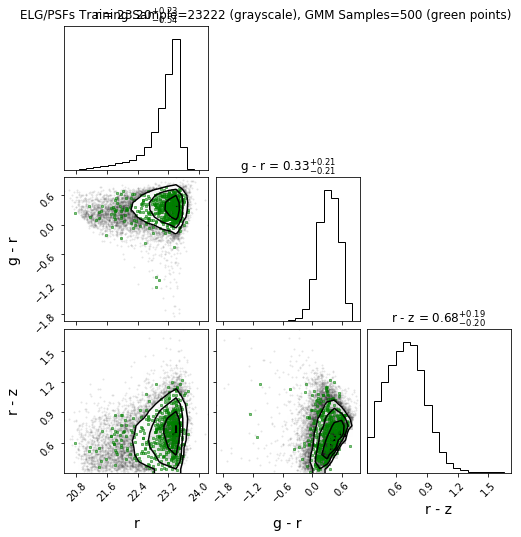

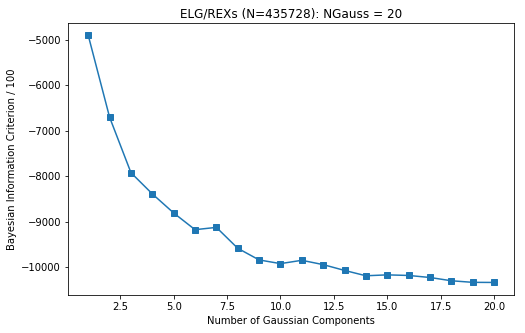

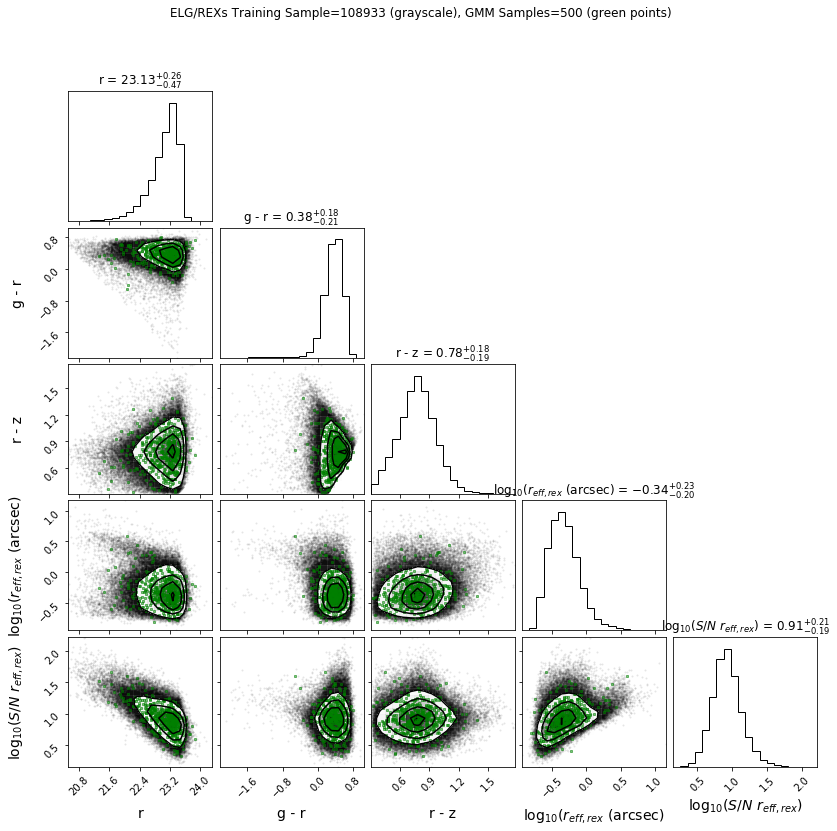

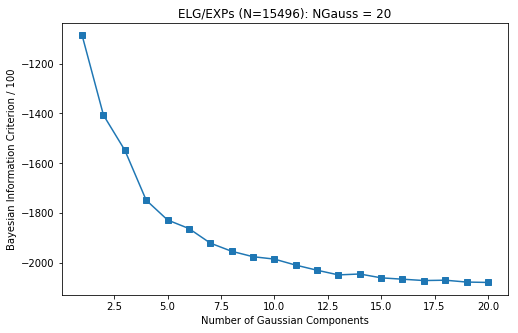

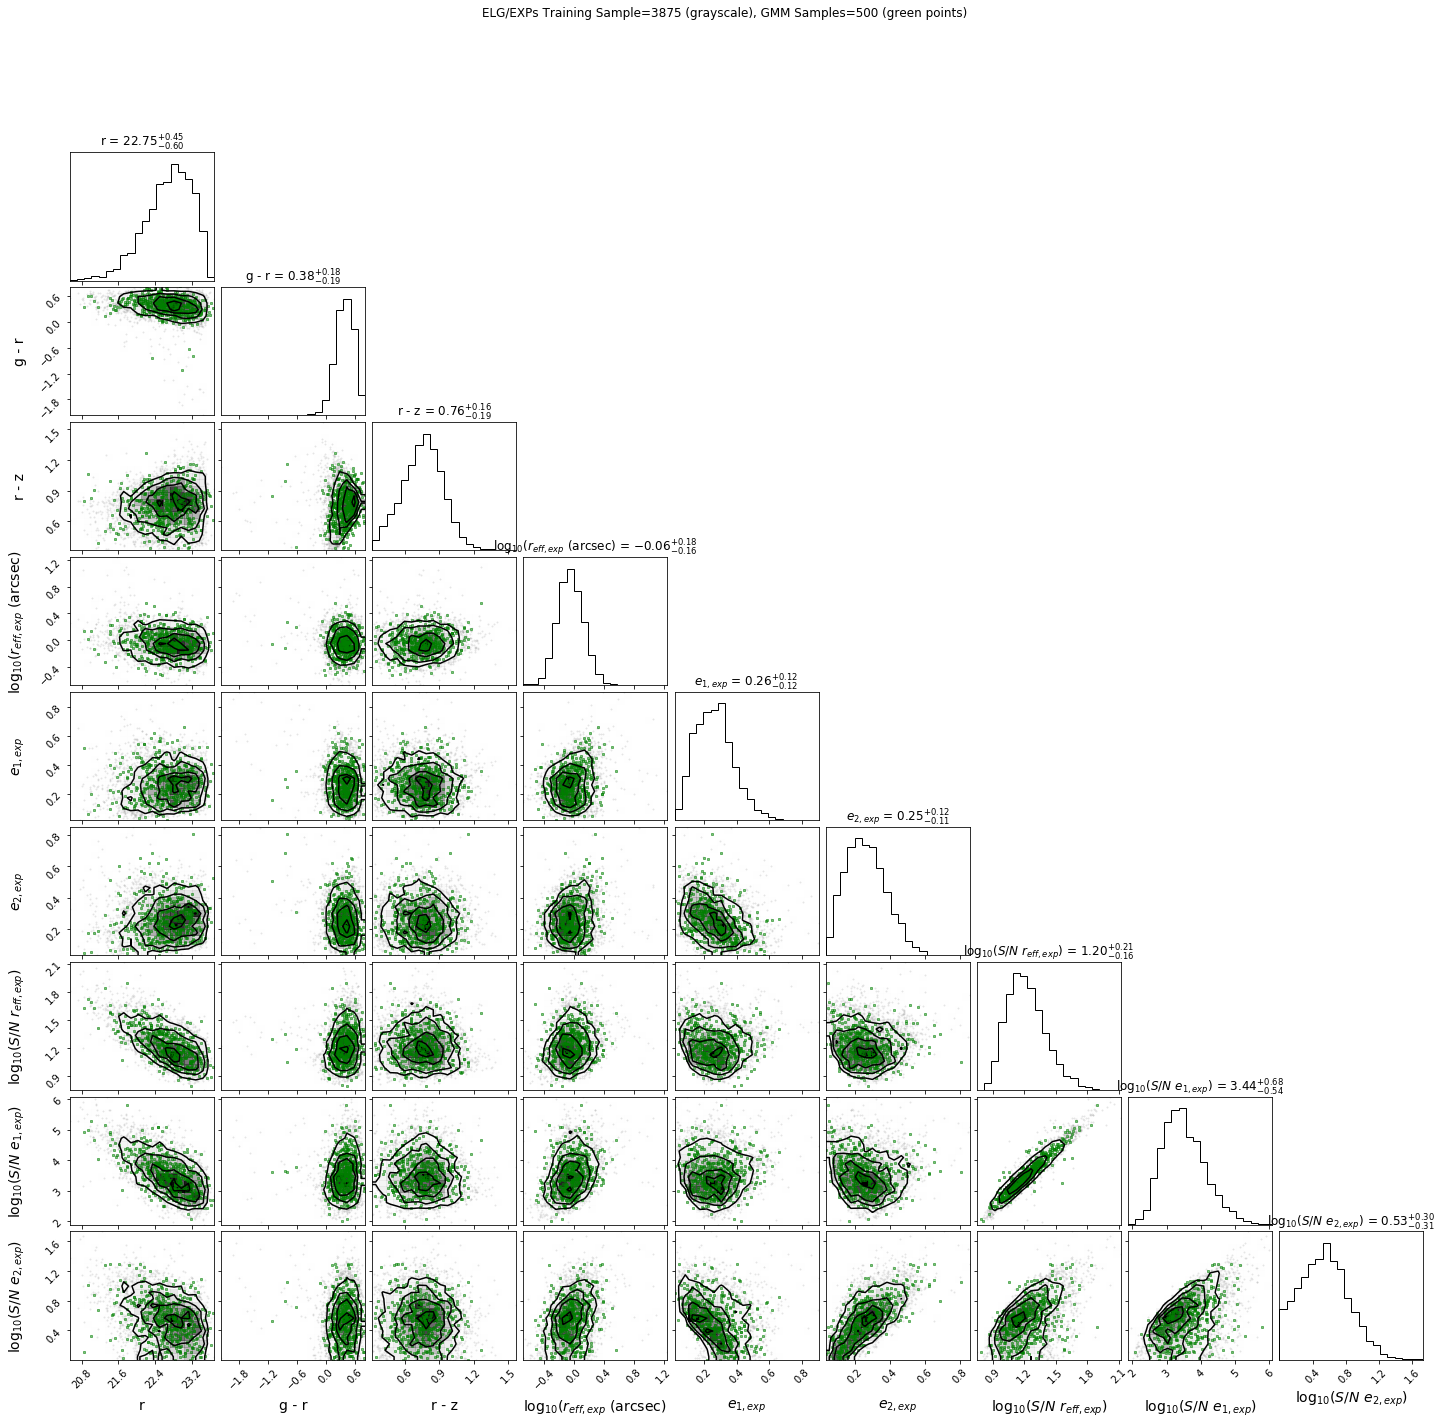

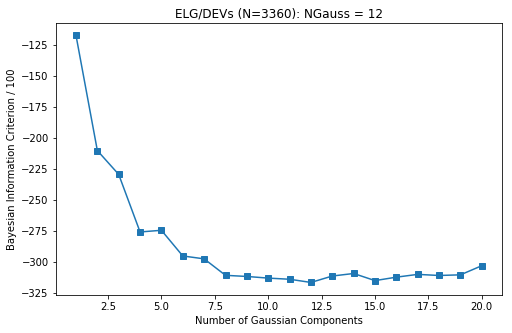

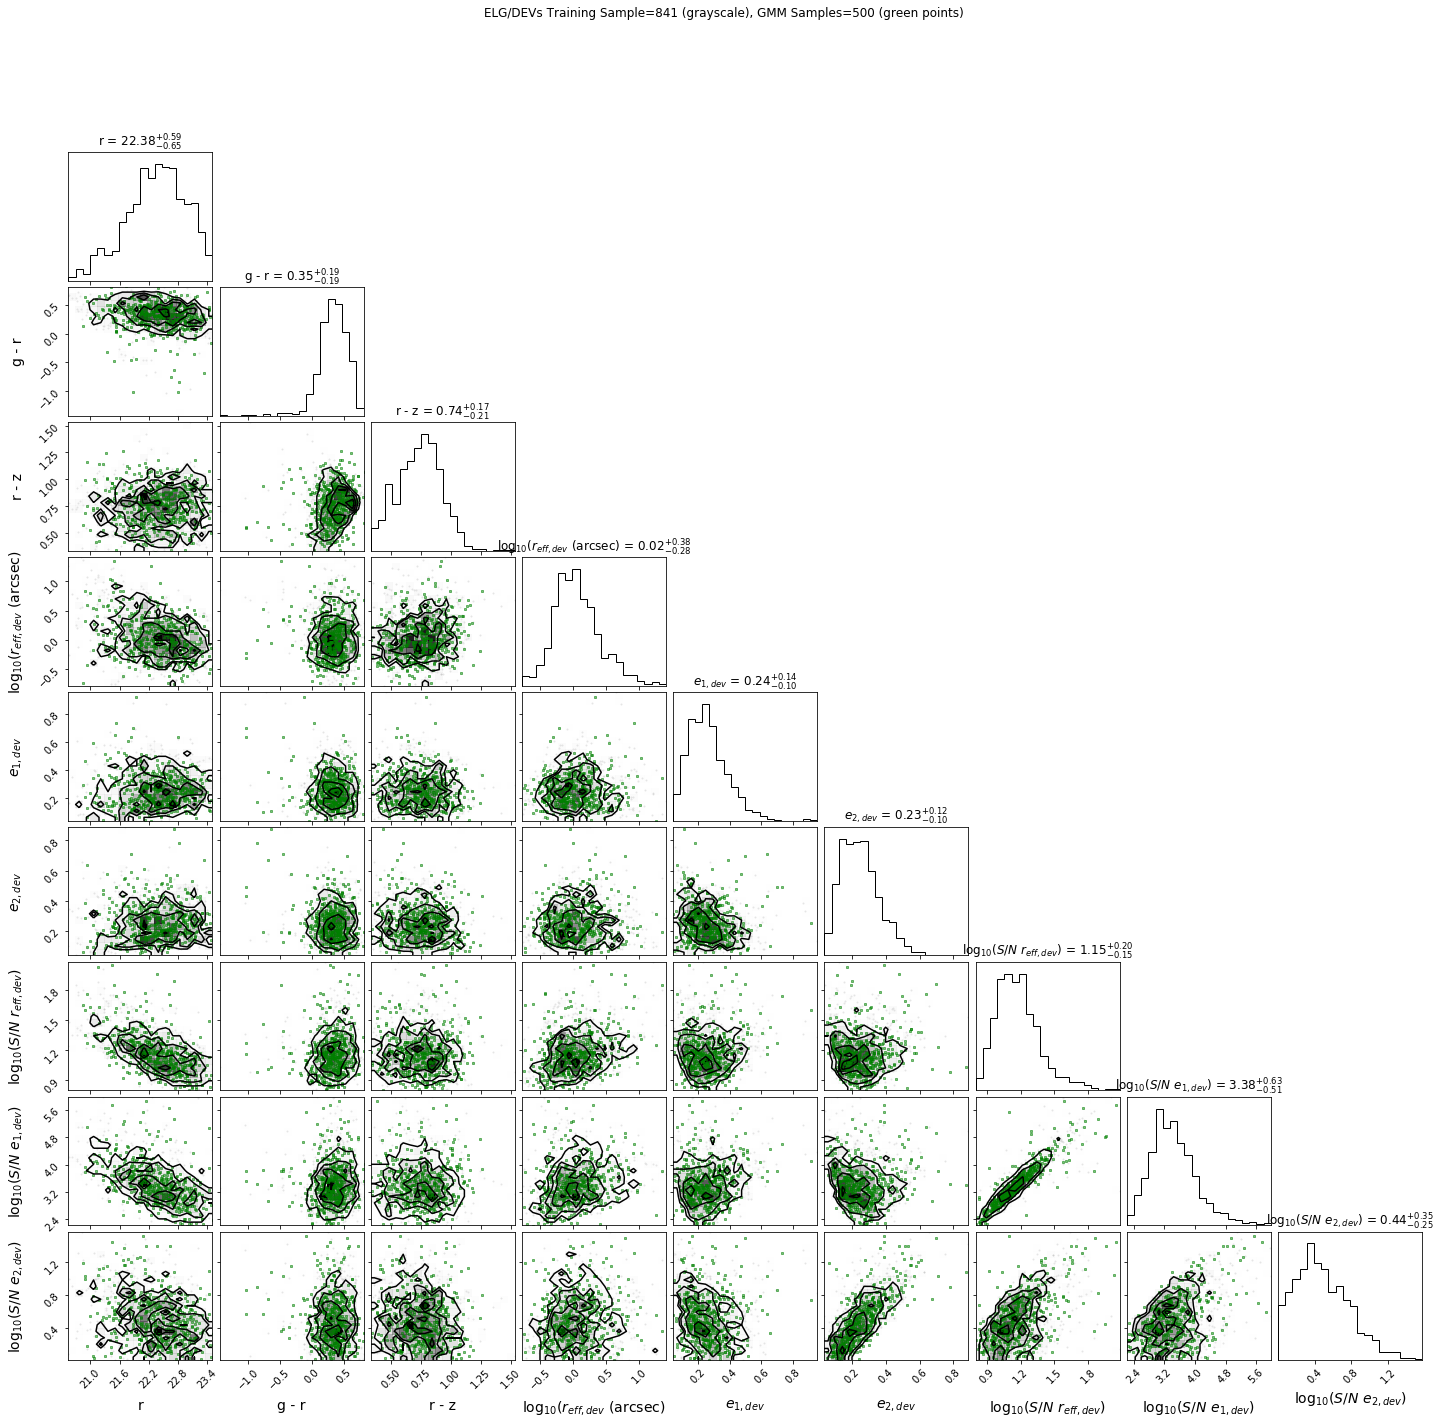

In [26]:
%time train_and_validate('ELG', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)

### BGS

No  BGS/PSF s selected.
Training:testing 59384:14846 BGS/REXs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_bgs_rex.fits

Training:testing 26023:6506 BGS/EXPs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_bgs_exp.fits

Training:testing 31723:7931 BGS/DEVs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_bgs_dev.fits

Training:testing 1191:298 BGS/COMPs with 1-20 Gaussian components.
Writing /global/cscratch1/sd/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/dr7.1/gmm_bgs_comp.fits

CPU times: user 3min 42s, sys: 534 ms, total: 3min 42s
Wall time: 3min 43s


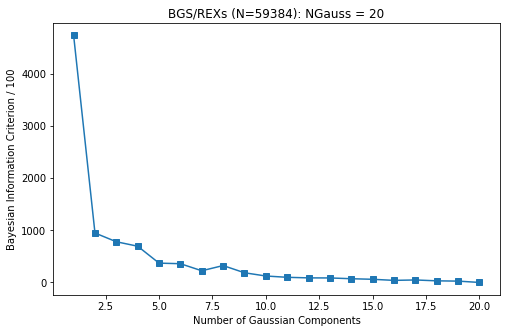

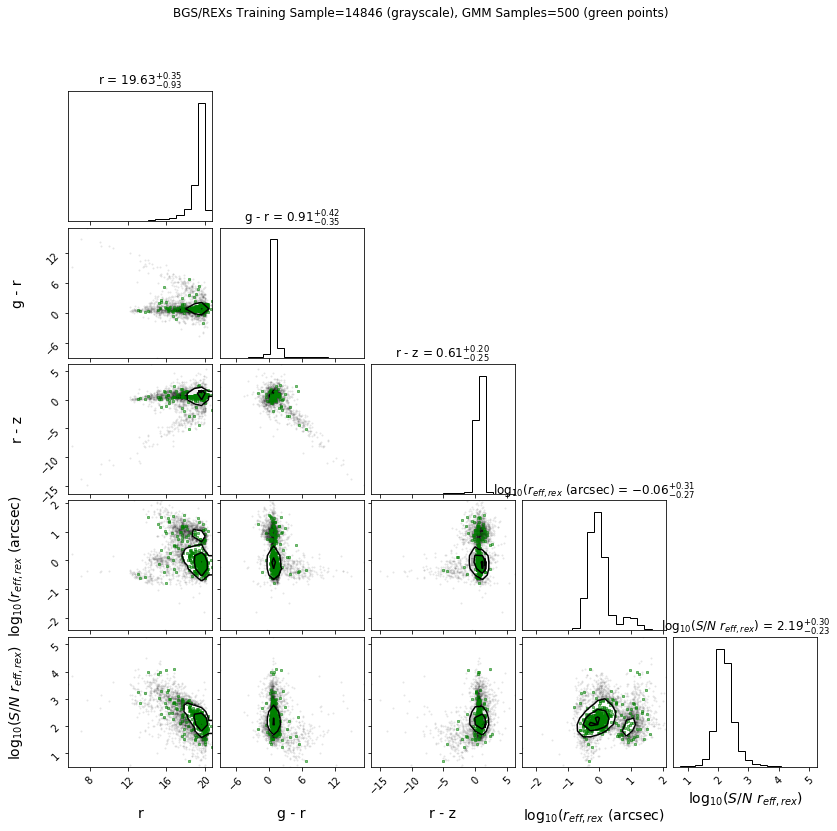

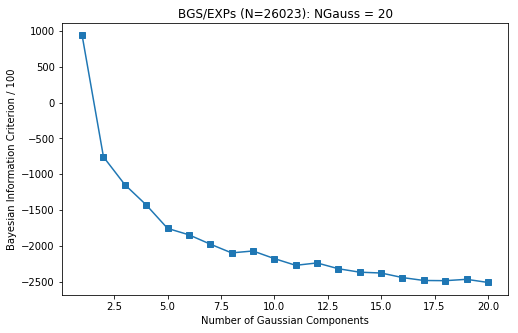

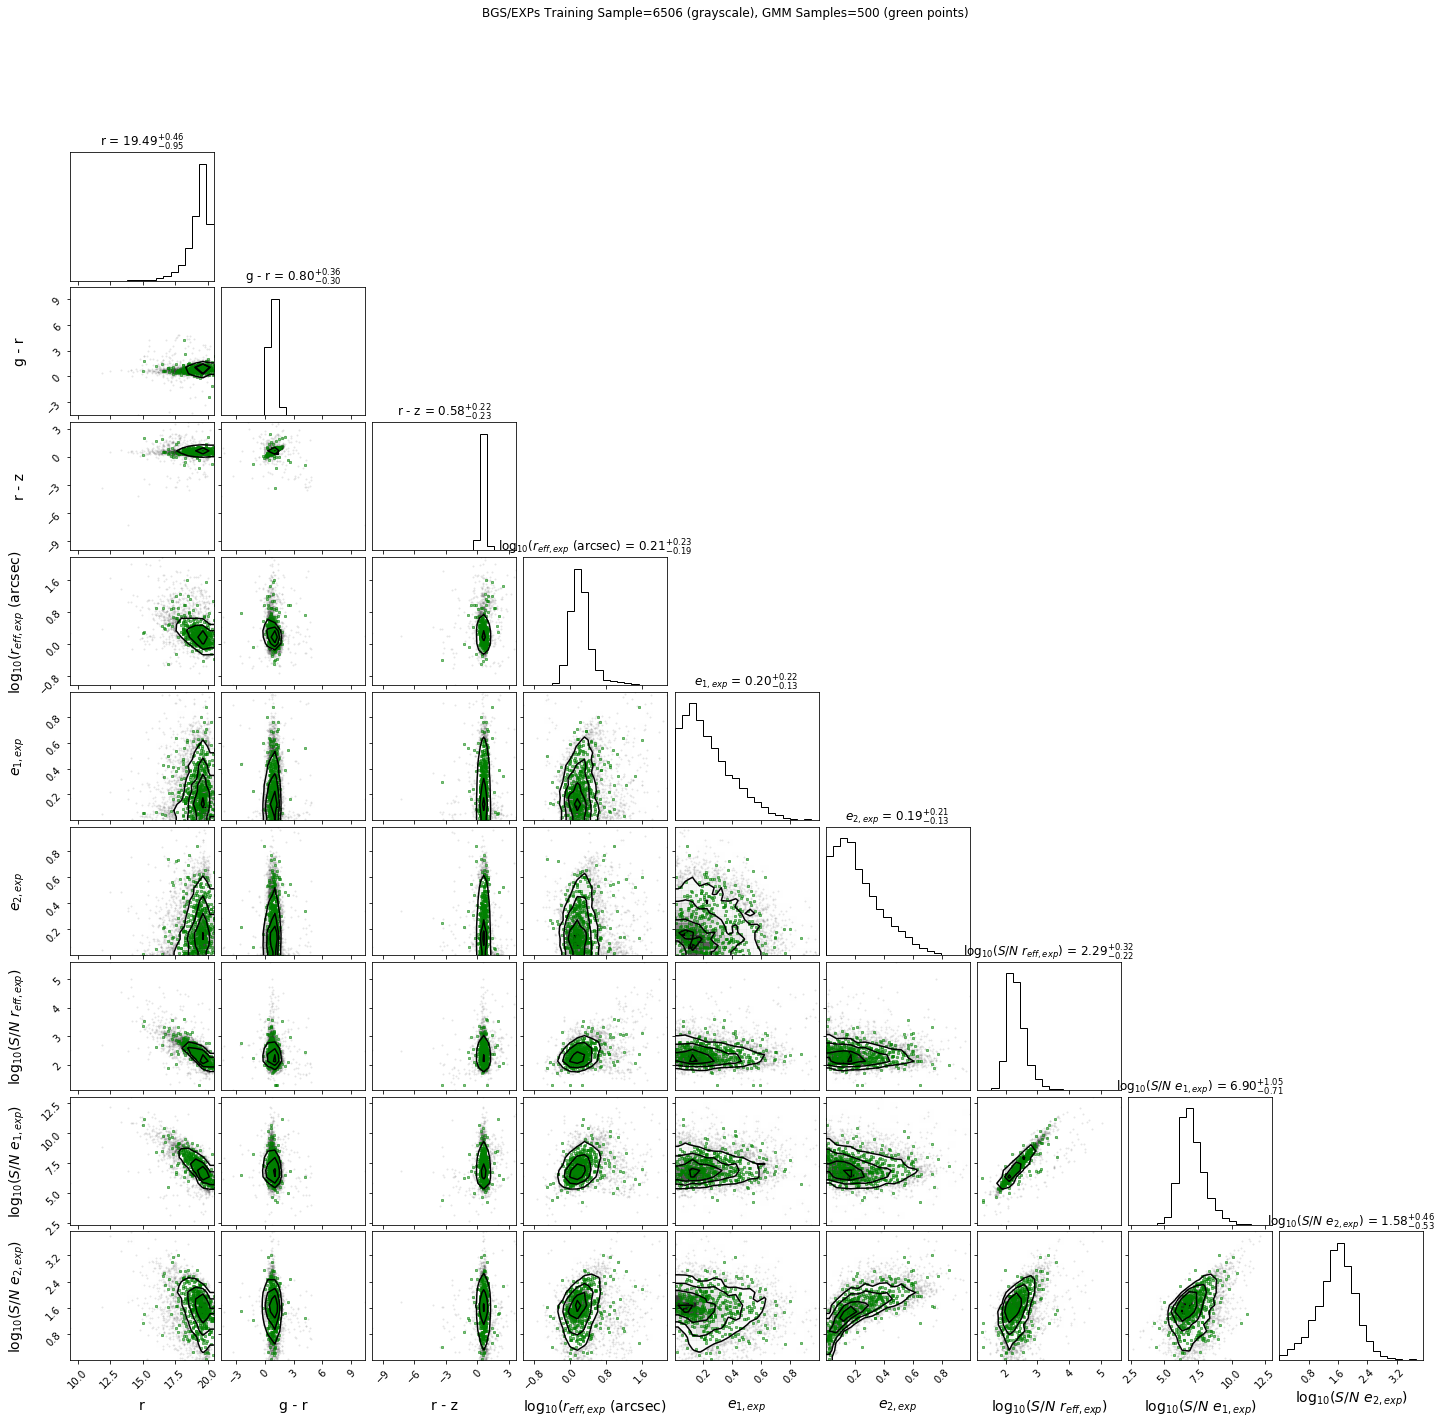

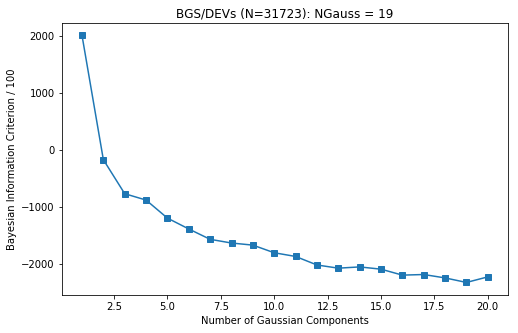

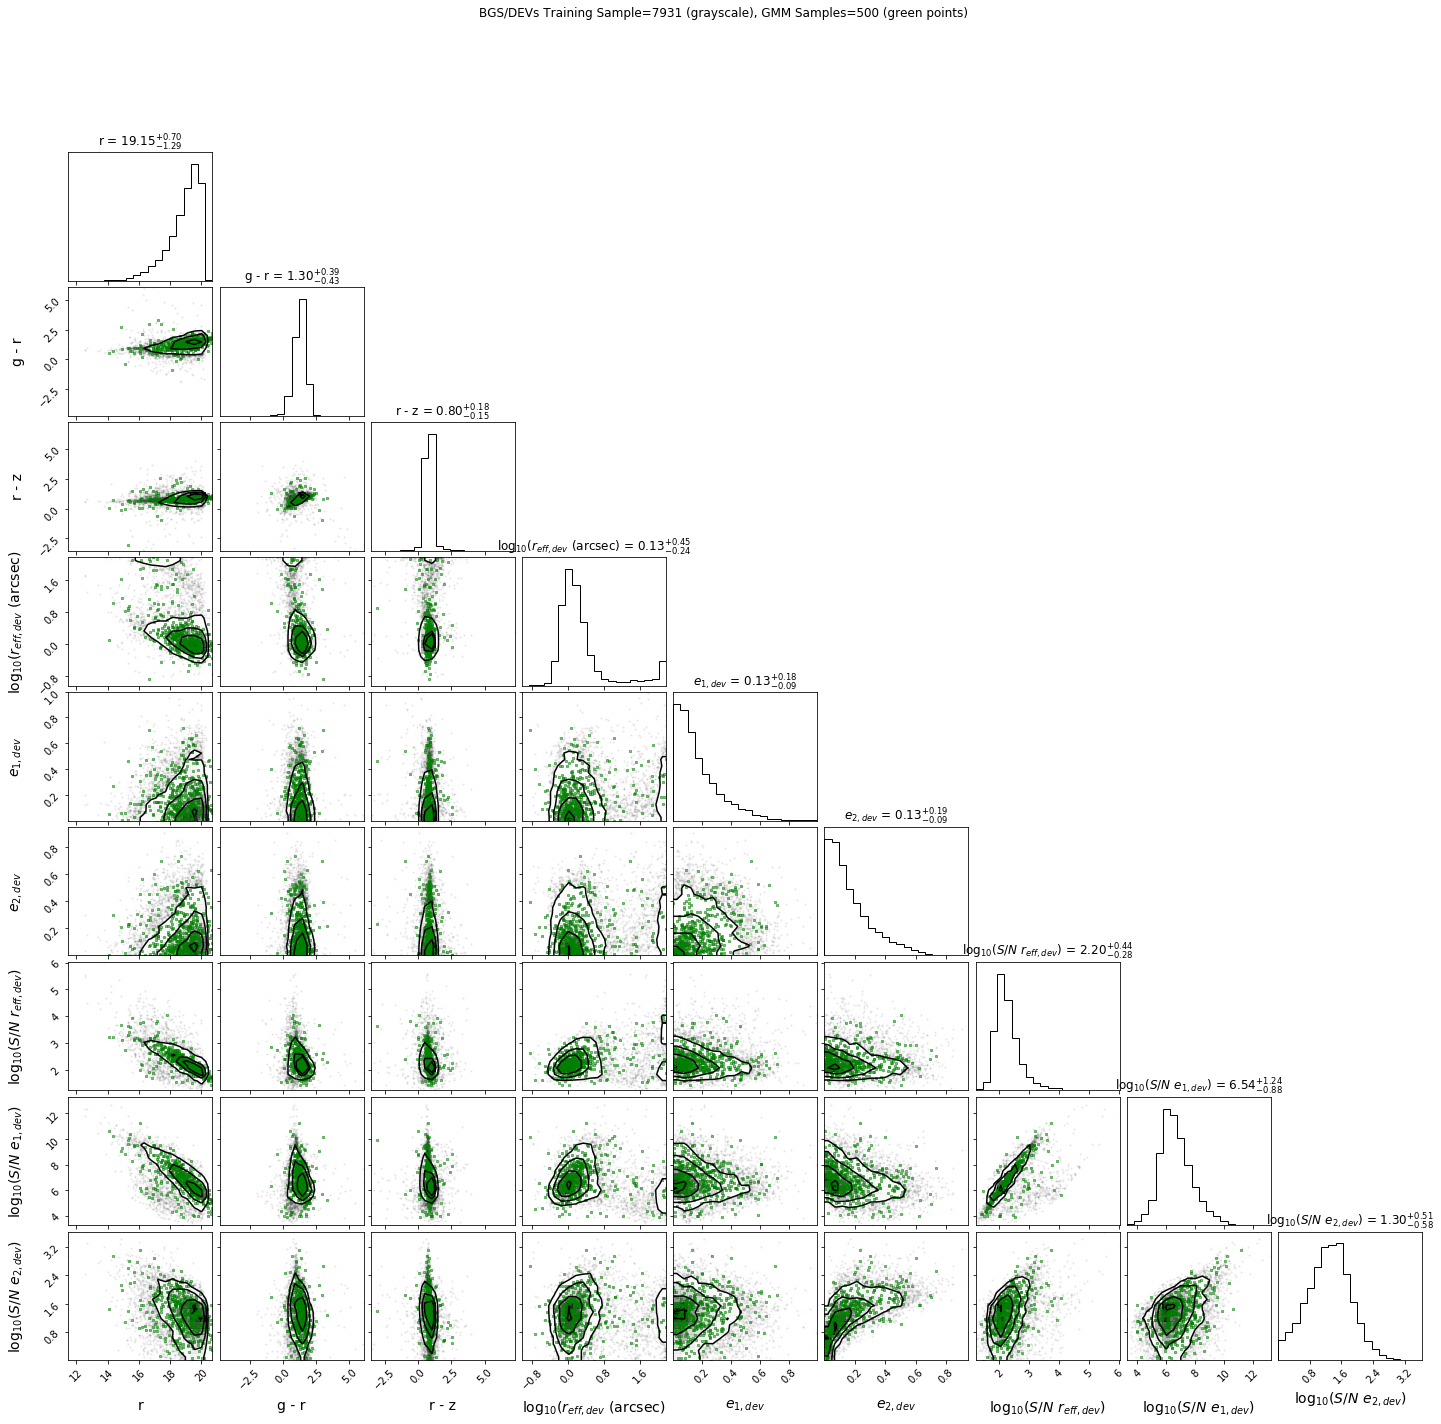

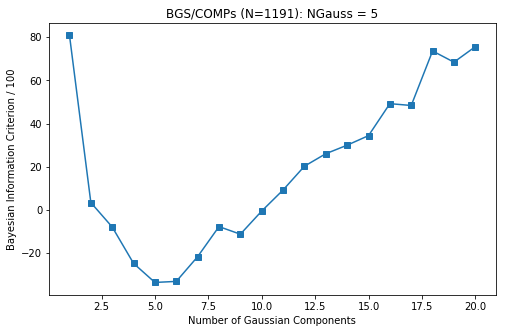

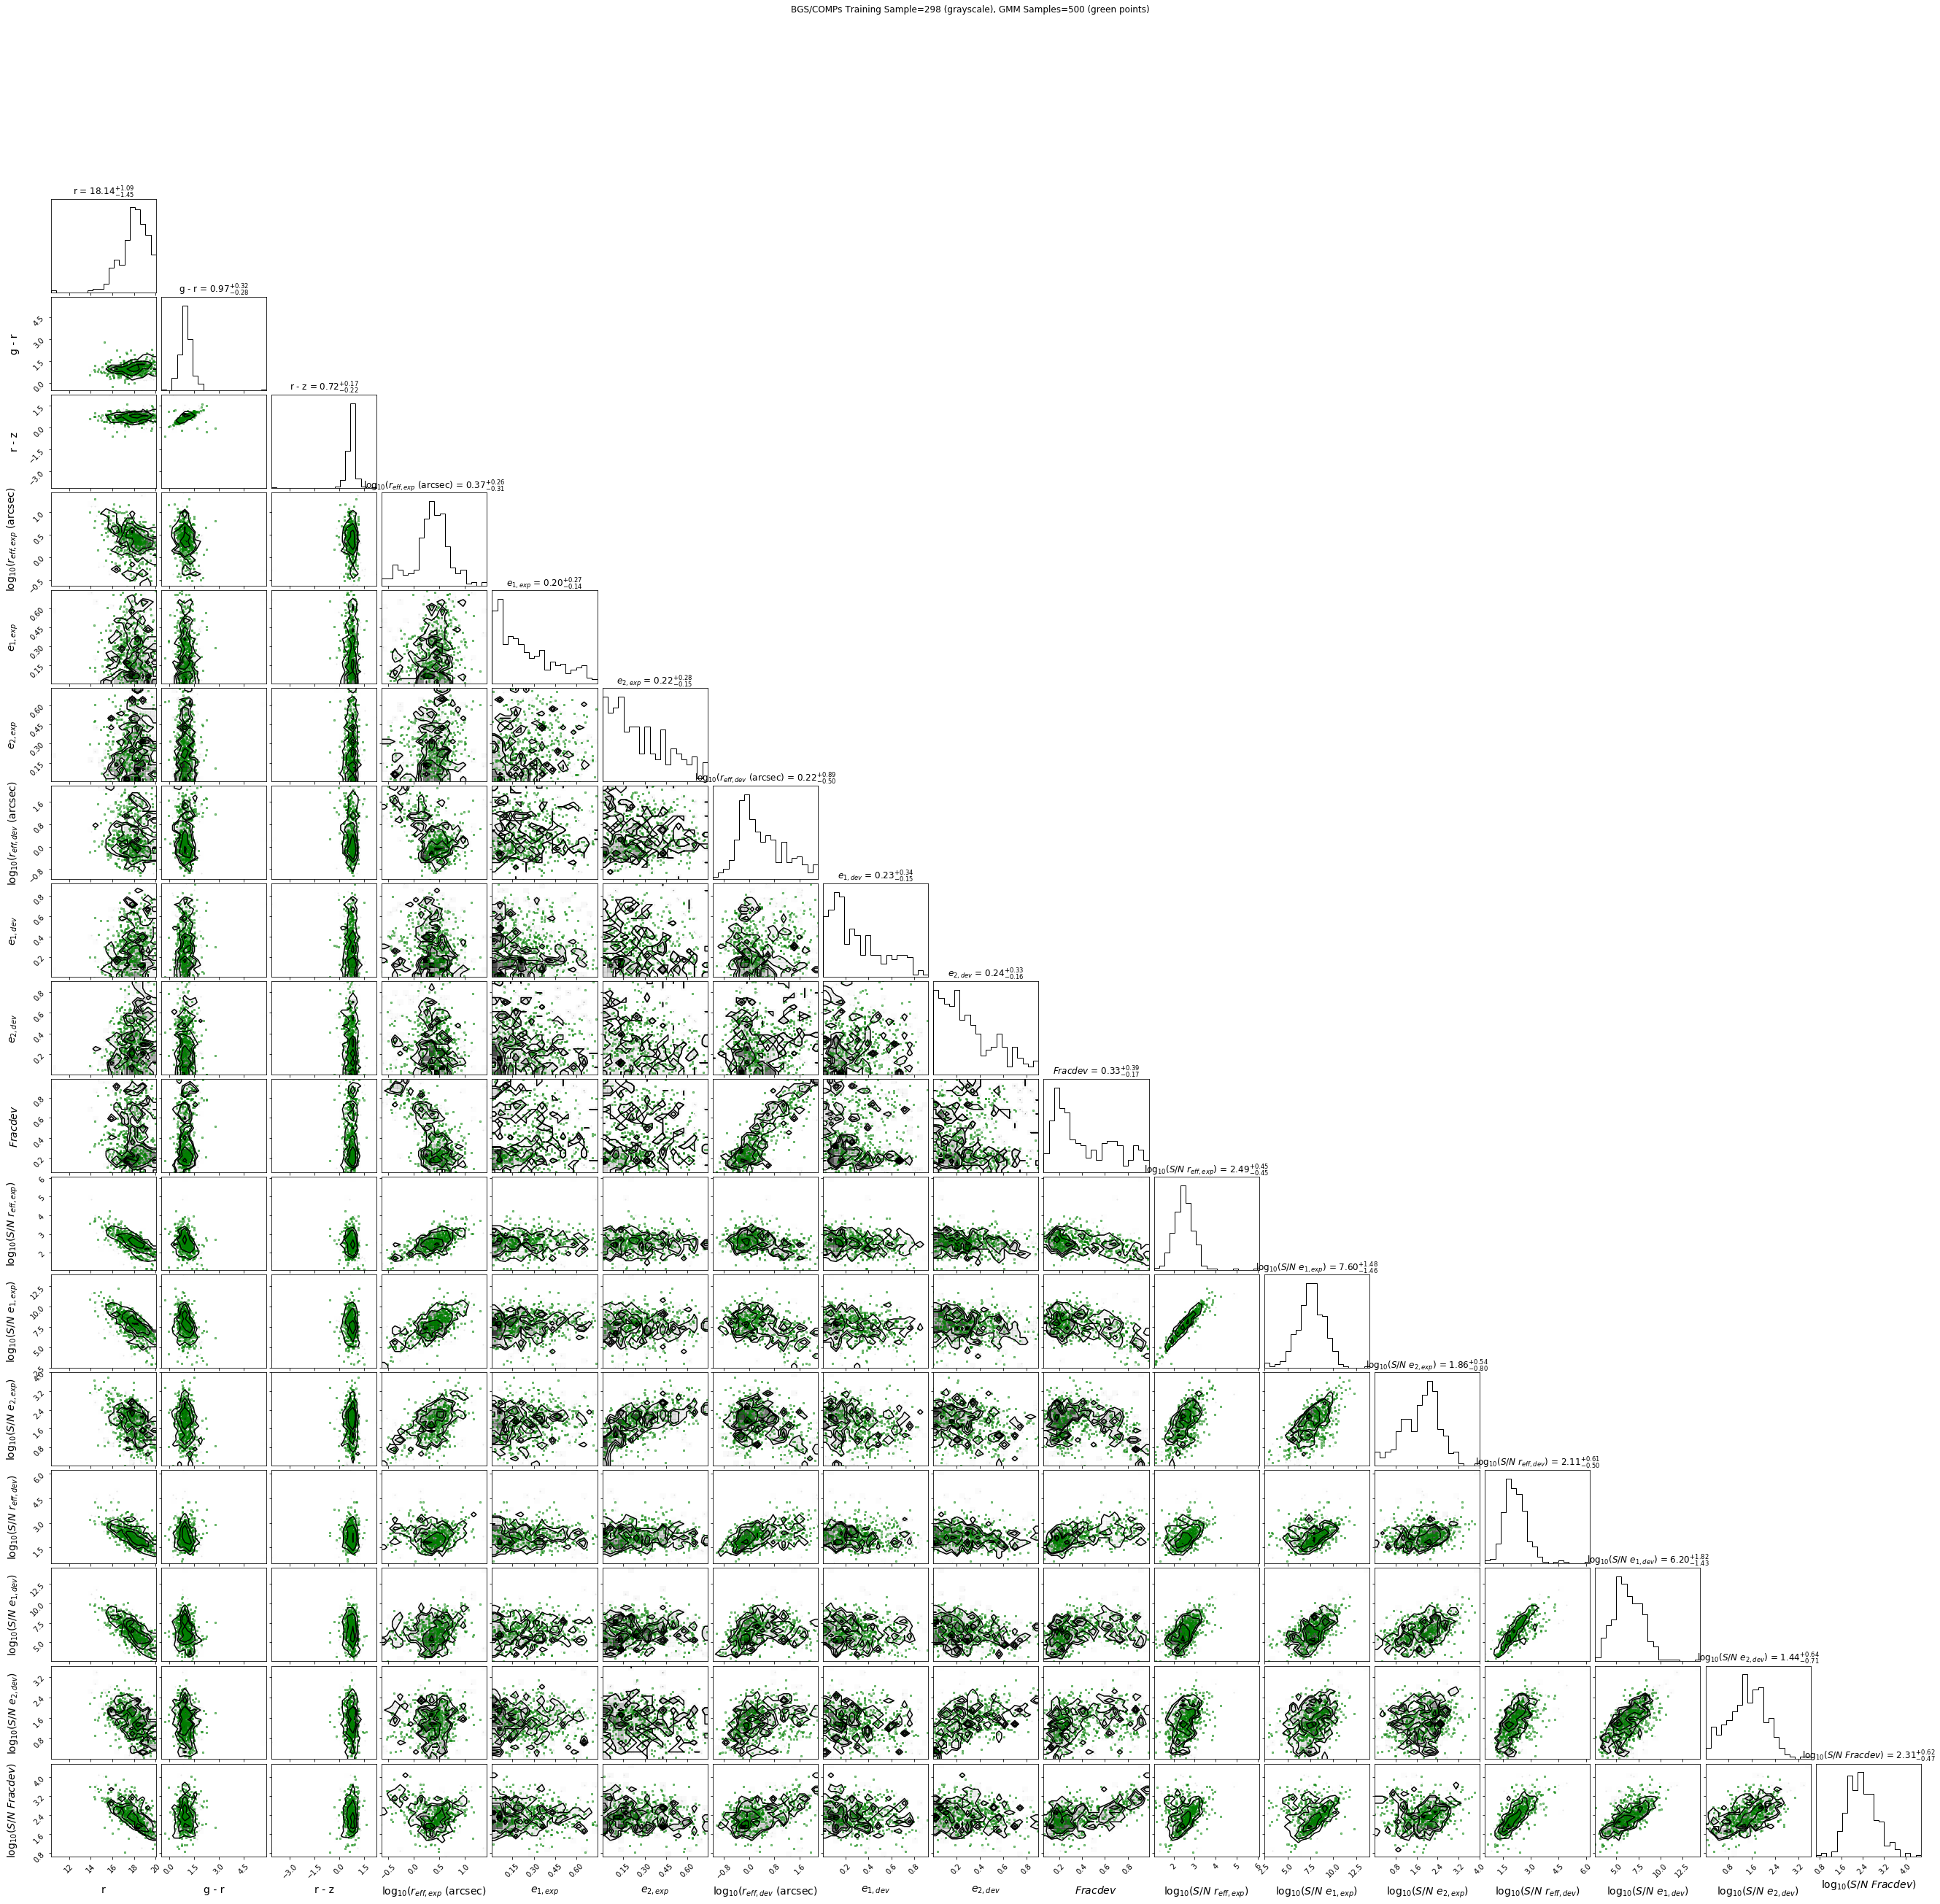

In [27]:
%time train_and_validate('BGS', Nsample=500, Nmax=None, ncompmax=ncompmax, overwrite=overwrite)